In [1]:
!pip install albumentations
!pip install timm
!pip install transformers



In [2]:
import os
import cv2
import gc
import json
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer


<ipython-input-2-aaa55f4caea2>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Imports
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import itertools
from torch.nn import functional as F
from transformers import MarianMTModel, MarianTokenizer, DistilBertTokenizer, DistilBertModel, DistilBertConfig
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

# Configuration
class CFG:
    debug = False
    image_path = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'
    captions_path = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset'
    batch_size = 32
    num_workers = 2
    head_lr = 1e-4
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-4
    patience = 1
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True
    trainable = True
    temperature = 1.0
    size = 224
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.3

In [5]:
# Translator Module
class Translator:
    def __init__(self, model_name="Helsinki-NLP/opus-mt-bn-en"):
        self.tokenizer = MarianTokenizer.from_pretrained(model_name)
        self.model = MarianMTModel.from_pretrained(model_name)

    def translate(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        translation = self.model.generate(**tokens)
        translated_texts = self.tokenizer.batch_decode(translation, skip_special_tokens=True)
        return translated_texts[0]

translator = Translator()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/806k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/309M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [6]:
# Data Loading and Preprocessing
def load_captions():
    with open(os.path.join(CFG.captions_path, 'BAN-Cap_captiondata.json'), 'r', encoding='utf-8') as f:
        captions_data = json.load(f)

    captions_list = []
    for entry in captions_data:
        if 'caption_id' in entry and 'english_caption' in entry:
            filename = entry['caption_id'].split('#')[0]
            caption = entry['english_caption']
            captions_list.append({
                "image": filename,
                "caption_number": "0",  # Default caption number
                "caption": caption
            })

    df = pd.DataFrame(captions_list)
    df['id'] = df.index // 5  # Assuming 5 captions per image
    return df

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]



In [7]:
import torch
import os
import cv2

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        Dataset class for CLIP, handling image-caption pairs.
        Args:
        - image_filenames: List of image file paths.
        - captions: List of captions corresponding to the images.
        - tokenizer: Tokenizer instance for text tokenization.
        - transforms: Image transforms to apply.
        """
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        # Read and process the image
        image_path = os.path.join(CFG.image_path, self.image_filenames[idx])
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        item["image"] = torch.tensor(image).permute(2, 0, 1).float()
        # Ensure caption is included in the batch
        item["caption"] = self.captions[idx]
        return item

    def __len__(self):
        """
        Returns the total number of items in the dataset.
        """
        return len(self.captions)


In [8]:

class ImageEncoder(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


In [9]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

        # Cache for translated captions to avoid repeated translations
        self.translation_cache = {}

    def get_translated_caption(self, caption):
        """Cache translations to improve performance"""
        if caption not in self.translation_cache:
            self.translation_cache[caption] = translator.translate(caption)
        return self.translation_cache[caption]

    def forward(self, batch, translate_prompt=False):
        # Get batch size
        batch_size = batch["image"].size(0)

        # Handle translation without affecting the original training flow
        if translate_prompt:
            captions = [self.get_translated_caption(cap) for cap in batch["caption"]]
        else:
            captions = batch["caption"]

        # Tokenize captions efficiently
        tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
        encoded_captions = tokenizer(
            captions,
            padding=True,
            truncation=True,
            max_length=CFG.max_length,
            return_tensors="pt",
        ).to(CFG.device)

        # Process image and text in parallel
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=encoded_captions["input_ids"],
            attention_mask=encoded_captions["attention_mask"],
        )

        # Project features efficiently
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Normalize embeddings
        image_embeddings = F.normalize(image_embeddings, dim=-1)
        text_embeddings = F.normalize(text_embeddings, dim=-1)

        # Calculate similarity with temperature scaling
        logits = (text_embeddings @ image_embeddings.T) / self.temperature

        # Calculate loss using efficient matrix operations
        labels = torch.arange(batch_size, device=CFG.device)
        loss = (
            F.cross_entropy(logits, labels) +
            F.cross_entropy(logits.T, labels)
        ) / 2.0

        return loss

    def compute_similarity(self, images, captions, translate_prompt=False):
        """Optimized similarity computation"""
        with torch.no_grad():
            # Extract embeddings
            image_embeddings = self.extract_image_features(images)
            text_embeddings = self.extract_text_features(captions, translate_prompt)

            # Compute similarity efficiently
            similarity = (text_embeddings @ image_embeddings.T) / self.temperature

        return similarity

    def extract_image_features(self, images):
        """Optimized image feature extraction"""
        with torch.no_grad():
            image_features = self.image_encoder(images)
            image_embeddings = self.image_projection(image_features)
            return F.normalize(image_embeddings, dim=-1)

    def extract_text_features(self, captions, translate_prompt=False):
        """Optimized text feature extraction with caching"""
        with torch.no_grad():
            if translate_prompt:
                captions = [self.get_translated_caption(cap) for cap in captions]

            tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
            encoded_captions = tokenizer(
                captions,
                padding=True,
                truncation=True,
                max_length=CFG.max_length,
                return_tensors="pt",
            ).to(CFG.device)

            text_features = self.text_encoder(
                input_ids=encoded_captions["input_ids"],
                attention_mask=encoded_captions["attention_mask"],
            )
            text_embeddings = self.text_projection(text_features)
            return F.normalize(text_embeddings, dim=-1)


In [10]:

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [11]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.8, 1.0)),  # Add cropping
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ])



In [12]:

def make_train_valid_dfs():
    dataframe = load_captions()
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [13]:

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader


def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [14]:
# Training function with a green progress bar
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader), colour="green")
    for batch in tqdm_object:
        # Retain captions before moving tensors to device
        captions = batch["caption"]
        # Move other tensors to device
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        # Add captions back to batch
        batch["caption"] = captions

        # Regular training without translation
        loss = model(batch, translate_prompt=False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def validate(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader), colour="blue")
    for batch in tqdm_object:
        captions = batch["caption"]
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        batch["caption"] = captions

        # Regular validation without translation
        loss = model(batch, translate_prompt=False)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


# Main interface for training
def main():
    print("Starting training...")
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = validate(model, valid_loader)

        print(f"Training Loss: {train_loss.avg:.4f}, Validation Loss: {valid_loss.avg:.4f}")

        # Step LR scheduler after each epoch
        if step == "epoch":
            lr_scheduler.step(valid_loss.avg)

        # Save the model if it achieves the best validation loss
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved best model with validation loss:", best_loss)

if __name__ == "__main__":
    main()



Starting training...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


100%|██████████| 253/253 [05:16<00:00,  1.25s/it, valid_loss=2.9]


Training Loss: 2.8405, Validation Loss: 2.9030
Saved best model with validation loss: 2.9030136282865433
Epoch: 2


100%|██████████| 253/253 [01:43<00:00,  2.45it/s, valid_loss=2.89]


Training Loss: 2.7206, Validation Loss: 2.8896
Saved best model with validation loss: 2.8895682755742587
Epoch: 3


100%|██████████| 253/253 [01:41<00:00,  2.50it/s, valid_loss=2.88]


Training Loss: 2.6889, Validation Loss: 2.8848
Saved best model with validation loss: 2.884829277632705
Epoch: 4


100%|██████████| 253/253 [01:46<00:00,  2.38it/s, valid_loss=2.88]


Training Loss: 2.6703, Validation Loss: 2.8801
Saved best model with validation loss: 2.880114082058222
Epoch: 5


100%|██████████| 253/253 [01:47<00:00,  2.36it/s, valid_loss=2.88]


Training Loss: 2.6565, Validation Loss: 2.8776
Saved best model with validation loss: 2.8775698974783843
Epoch: 6


100%|██████████| 253/253 [01:45<00:00,  2.40it/s, valid_loss=2.88]


Training Loss: 2.6473, Validation Loss: 2.8782
Epoch: 7


100%|██████████| 253/253 [01:45<00:00,  2.39it/s, valid_loss=2.88]


Training Loss: 2.6393, Validation Loss: 2.8778
Epoch: 8


100%|██████████| 253/253 [01:45<00:00,  2.40it/s, valid_loss=2.88]


Training Loss: 2.6321, Validation Loss: 2.8753
Saved best model with validation loss: 2.8752942324568815
Epoch: 9


100%|██████████| 253/253 [01:46<00:00,  2.38it/s, valid_loss=2.88]


Training Loss: 2.6263, Validation Loss: 2.8798
Epoch: 10


100%|██████████| 253/253 [01:46<00:00,  2.39it/s, valid_loss=2.88]

Training Loss: 2.6203, Validation Loss: 2.8801


In [17]:
import torch

# Define the Google Drive path for saving the model
save_path = "/content/drive/MyDrive/Bangla Image dataset with caption/translationclipenglish2.pt"

# Define your model class (ensure this matches the architecture used during training)
model = CLIPModel().to(CFG.device)  # Replace CLIPModel with your actual model class

# Load the trained model from the saved state dictionary
checkpoint_path = "/content/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path))

# Save the model's state dictionary to the specified Google Drive path
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully at: {save_path}")


<ipython-input-17-984ac6da5be9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model saved successfully at: /content/drive/MyDrive/Bangla Image dataset with caption/translationclipenglish2.pt


#Interface

<ipython-input-13-a33112d01e1a>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))
100%|██████████| 253


Searching for: পাহাড়
Bangla Query: পাহাড়
English Translation: Mountains


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2489 (\N{BENGALI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2465 (\N{BENGALI LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/di

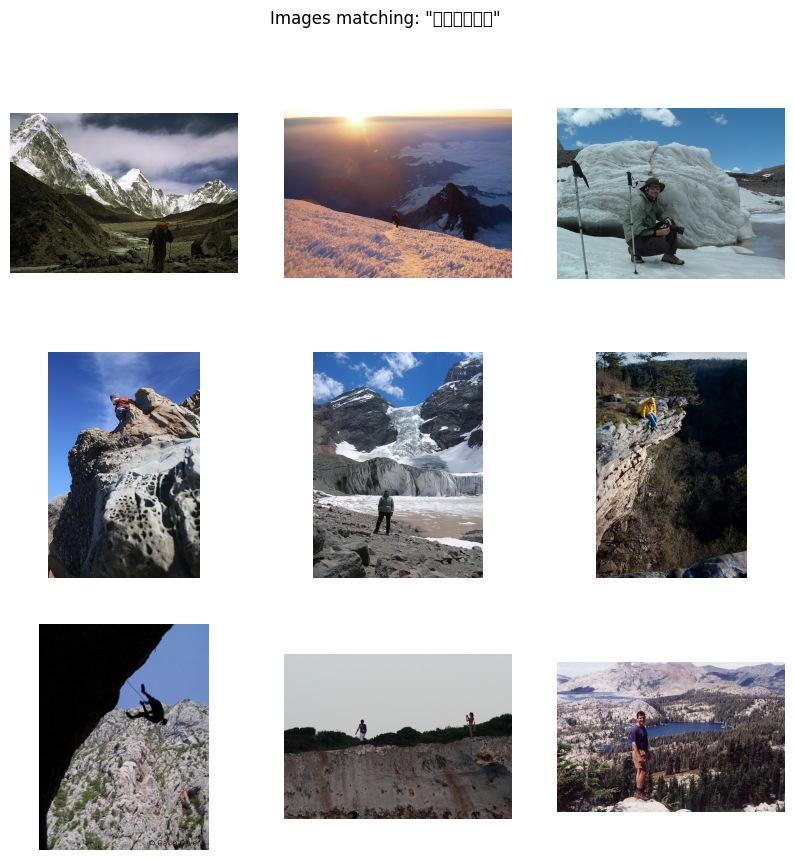


Searching for: নদী
Bangla Query: নদী
English Translation: River


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2472 (\N{BENGALI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2470 (\N{BENGALI LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2496 (\N{BENGALI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


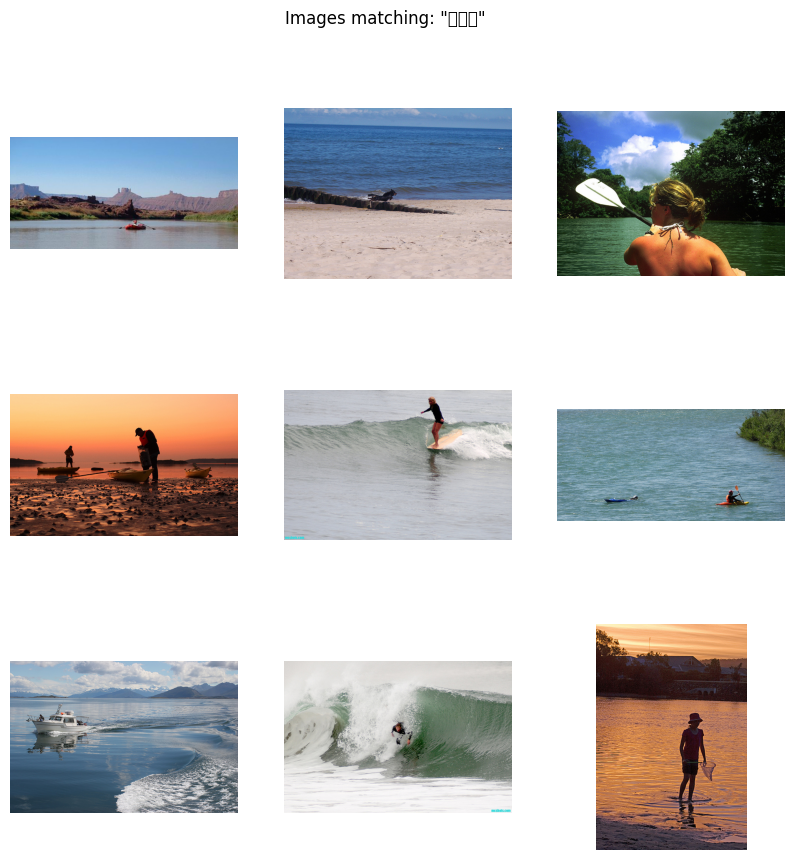


Searching for: সূর্য
Bangla Query: সূর্য
English Translation: Sun


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2498 (\N{BENGALI VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2509 (\N{BENGALI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2479 (\N{BENGALI LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


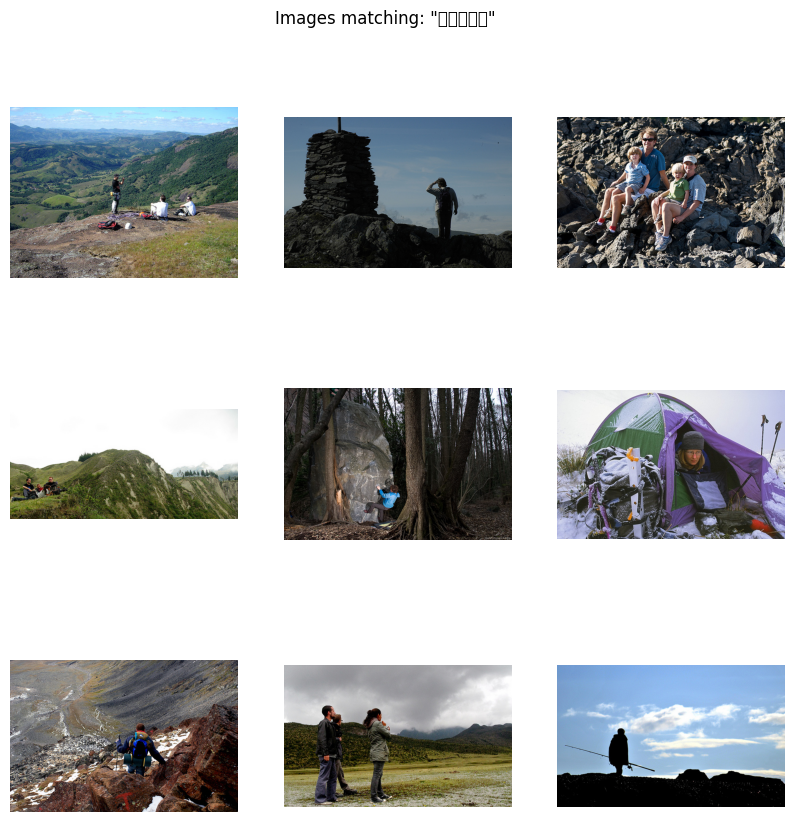


Searching for: ফুল
Bangla Query: ফুল
English Translation: Flowers


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2475 (\N{BENGALI LETTER PHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2497 (\N{BENGALI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


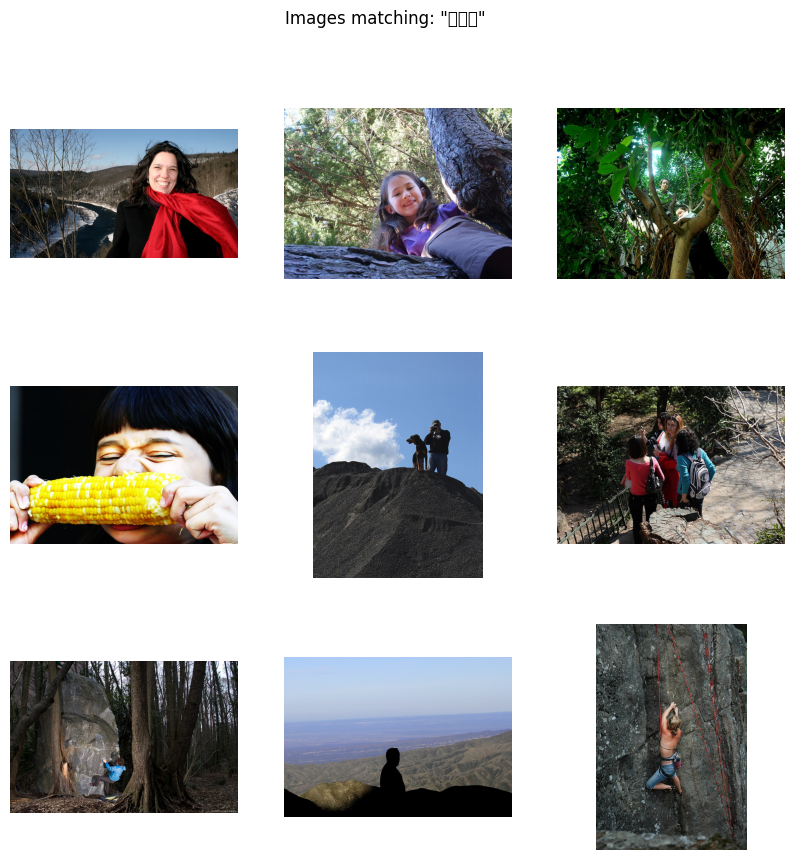

In [19]:
def find_matches_bangla(model, image_embeddings, bangla_query, image_filenames, n=9, show_translation=True):
    """
    Finds the top `n` matches for a Bangla text query among the image embeddings and displays them.

    Parameters:
    - model: Trained CLIPModel instance
    - image_embeddings: Tensor of image embeddings from the validation set
    - bangla_query: Text query in Bangla to search for matching images
    - image_filenames: List of filenames corresponding to the images
    - n: Number of matches to display (default: 9)
    - show_translation: Whether to print the English translation (default: True)
    """
    try:
        # Translate Bangla query to English
        english_query = translator.translate(bangla_query)

        if show_translation:
            print(f"Bangla Query: {bangla_query}")
            print(f"English Translation: {english_query}")

        tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
        encoded_query = tokenizer(
            [english_query],
            padding=True,
            truncation=True,
            max_length=CFG.max_length,
            return_tensors="pt"
        )

        batch = {
            key: values.to(CFG.device)
            for key, values in encoded_query.items()
        }

        with torch.no_grad():
            # Encode the text query
            text_features = model.text_encoder(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            text_embeddings = model.text_projection(text_features)

        # Normalize the embeddings
        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

        # Compute similarity and get top matches
        dot_similarity = text_embeddings_n @ image_embeddings_n.T
        values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
        matches = [image_filenames[idx] for idx in indices[::5]]

        # Display the matched images
        _, axes = plt.subplots(3, 3, figsize=(10, 10))
        for match, ax in zip(matches, axes.flatten()):
            image_path = os.path.join(CFG.image_path, match)
            image = cv2.imread(image_path)
            if image is None:
                ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis("off")

        plt.suptitle(f'Images matching: "{bangla_query}"', y=0.95)
        plt.show()

        return matches, values.tolist()

    except Exception as e:
        print(f"Error processing query: {str(e)}")
        return [], []

# Example usage
if __name__ == "__main__":
    # Load the model and data
    _, valid_df = make_train_valid_dfs()
    model, image_embeddings = get_image_embeddings(valid_df, "best_model.pth")

    # Example Bangla queries
    bangla_queries = [
        "পাহাড়",  # hill
        "নদী",    # river
        "সূর্য",   # sun
        "ফুল"     # flower
    ]

    # Test with a Bangla query
    for query in bangla_queries:
        print("\nSearching for:", query)
        matches, scores = find_matches_bangla(
            model=model,
            image_embeddings=image_embeddings,
            bangla_query=query,
            image_filenames=valid_df['image'].values,
            n=9,
            show_translation=True
        )